# Exploitation - Label Prediction

In the exploitation task, we aim to predict the type of edges (transport routes). We start with Hand crafted features, followed by node embedding and finally use GNNs. In this notebook, we will work using the hand-crafted features.

## Task - 2

In the second task, we predict the edge labels between the given nodes. 

### Node2vec features

To compute the edge features between nodes, we combine the node features by subtracting the source node features from the target node features and then add the edge features.

**Imports**

In [1]:
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

from enum import Enum
from tqdm import tqdm
from matplotlib import pyplot as plt
from typing import Union, List, Dict, Literal, Tuple

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from skmultilearn.model_selection import iterative_train_test_split

from node2vec import Node2Vec

/Users/ravinithesh/miniconda3/envs/nml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Paths for input and output**

In [2]:
rel_data_folder_path = pathlib.Path("./../../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network = rel_data_folder_path.joinpath('network_graphs')
city_network_graphs = city_network.joinpath('graphs')
city_network_graphs_dir = city_network_graphs.joinpath('directed_graphs')
city_network_bones = city_network.joinpath('nodes-edges')

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_label_pred_node2vec = checkpoints_folder_path.joinpath('node2vec-label-pred')

**Utility Functions**

In [3]:
# Define enum for route types
class RouteType(Enum):
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name: str, graphs_folder: pathlib.Path) -> Dict[str, Union[float, List[List[int]], nx.Graph]]:
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: List[str], graphs_folder: pathlib.Path) -> Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]]:
    return {city: load_city_graphs(city, graphs_folder) for city in cities}

def Node2Vec_node_feature_extraction(graph: nx.Graph, num_features: int, p: float, q: float, seed: int) -> Dict[float, np.ndarray]:
    ''' 
    INPUT:
    graph: the graph
    num_features: dimension of node2vec embeddings, int
    p: float
    q: float
    seed: please always set to 0

    OUTPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
    '''
     
    node2vec_ = Node2Vec(graph, dimensions=num_features, p=p, q=q, seed=seed)
    model = node2vec_.fit()
    features_dict = {node: model.wv[idx] for idx, node in enumerate(graph.nodes())}
    return features_dict

def generate_edge_feature_targets(graph: nx.Graph, num_features: int, num_targets: int, p: float, q: float, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a node feature matrix for a given graph.

    Args:
        graph: The input graph.
        num_features: dimension of node2vec embeddings, int
        num_targets: Number of possible targets. It is 7 for the transport network.
        p: float
        q: float
        seed: Default to 0

    Returns:
        edge_features: The edge features.
        targes: target vector of dimension with values of {0, 1} for each mode of transport

    """
    
    edge_features = []
    targets = []
    
    node_features = Node2Vec_node_feature_extraction(graph, num_features=num_features, p=p, q=q, seed=seed)

    edges_unq = []

    for edge in graph.edges():
        if edge not in edges_unq:
            edges_unq.append(edge)
    
    for node1, node2 in edges_unq:
        node_1_feat = node_features[node1]
        node_2_feat = node_features[node2]
        comb_feature = np.subtract(node_2_feat, node_1_feat)
        edge_features.append(comb_feature)
        
        edge_data = graph.get_edge_data(node1, node2)
            
        target = np.zeros(num_targets)
        for edge_attr in edge_data.values():
            target[edge_attr['route_type']] = 1
        targets.append(target)

    return np.array(edge_features), np.array(targets)

def classifier(features: np.ndarray, targets: np.ndarray, route_classes: List[int], feature_selection: bool=False, num_features: int=1, test_size: float=0.5, seed: int=0, verbose: bool=False, input_feature_names: List[str]=[], title: str='') -> Tuple[np.ndarray, float, float]:
    ''' 
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
    targets: target vector of dimensions (N, ) (N: number of samples)
    route_classes: The classes of the route to consider for the given city.
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selesction
    test_size: please set to 0.5 for reproducibility
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set

    '''

    # Split the data into training and testing sets, with test_size
    np.random.seed(seed)
    X_train, y_train, X_test, y_test = iterative_train_test_split(features, targets, test_size=test_size)

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(StandardScaler(), MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=seed)))
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = ["feature_{}".format(str(i)) for i in range(features.shape[1])]
        print("\tThe feature scorees are:")
        print("\t{}".format({ft_name:ft_score for ft_name, ft_score in zip(input_feature_names, feature_selector.scores_)}))
        print("\tThe selected features are {}".format(feature_selector.get_feature_names_out(input_features=input_feature_names)))
    else:
        ## Build and train the ML model, including normalization and Logi.
        clf = make_pipeline(StandardScaler(), MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=seed)))
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("\t\tThe Weighted F1 score is {}".format(f1))
        print("\t\tThe Accuracy is {}".format(acc))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[RouteType(idx).name for idx in route_classes])
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc # type: ignore

def train_model(cities_graphs_dicts: Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]], cities_routes: Dict[str, List[int]], results_path: pathlib.Path, test_size: float, seed: int, num_features: int, p: float, q: float, num_targets: int, route_type: str) -> None:
    '''
    INPUT:
    cities_graphs_dicts: dictionary with keys as city names and values as dictionaries with keys as route types and values as route graphs
    cities_routes: Dictionay with keys as city names and values as the classes of the route to consider for the given city.
    results_path: path to save the results
    test_size: size of the test set, float
    seed: please set to 0 for reproducibility
    num_features: dimension of node2vec embeddings, int
    p: float
    q: float
    num_targets: possible number of targets, which is the number of modes of transport (7)
    route_type: the mode of transport graph of city to use, we will use full graph.
    
    OUTPUT:
    None
    
    '''
    
    results_path.mkdir(parents=True, exist_ok=True)

    for city, city_graphs in tqdm(cities_graphs_dicts.items()):
        city_graphs_scores = {}
        if city in cities_routes:
            route_graph = city_graphs[route_type]
            
            features_edges, targets_edge_all = generate_edge_feature_targets(route_graph, num_features=num_features, num_targets=num_targets, p=p, q=q, seed=seed)
            
            route_classes = cities_routes[city]
            targets_edge = targets_edge_all[:,route_classes]
            
            
            cm, f1score, accuracy = classifier(features_edges, targets_edge, route_classes,
                                    feature_selection=False, test_size=test_size,
                                    seed=seed, verbose=False)
            
            city_graphs_scores[route_type] = {"f1": f1score, "cm": cm, "acc": accuracy}
        else:
            city_graphs_scores[route_type] = {"f1": None, "cm": None, "acc": None}
            
        with open(results_path.joinpath('{}.gpickle'.format(city)), 'wb') as f:
            pickle.dump(city_graphs_scores, f, pickle.HIGHEST_PROTOCOL)
            
        print("Results saved")

def read_scores(results_path: pathlib.Path, modes_to_drop: List[str]) -> Tuple[Dict[str, Dict[str, Union[float, list[List[int]], nx.Graph]]], pd.DataFrame]:
    '''
    INPUT:
    results_path: path to read the results
    modes_to_drop: list of modes of transport to drop from the results
    
    OUTPUT:
    cities_graphs_scores: dictionary with keys as city names and values as dictionaries with keys as metric name and values as metrics
    cities_graphs_scores_df: dataframe with columns as city, route, metric name and metric value
    '''
    cities_reg = sorted([x.stem for x in results_path.glob('*.gpickle')])
    cities_graphs_scores = load_all_cities_graphs(cities_reg, results_path)
    cities_graphs_scores_df = pd.DataFrame.from_dict({(i,j): cities_graphs_scores[i][j] 
                           for i in cities_graphs_scores.keys() 
                           for j in cities_graphs_scores[i].keys()},
                       orient='index').reset_index(drop=False, names=['city', 'route'])
    
    if modes_to_drop:
        cities_graphs_scores_df = cities_graphs_scores_df[~cities_graphs_scores_df['route'].isin(modes_to_drop)]
    
    return cities_graphs_scores, cities_graphs_scores_df

def plot_cms(scores_dict: Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]], mode: str, cities_routes=Dict[str, List[int]]) -> None:
    fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=False, sharey=False)
    for idx, (city, city_scores_lr) in tqdm(enumerate(scores_dict.items())):

        row = int(idx / 5)
        col = idx % 5
        
        if city in cities_routes:
            labels = cities_routes[city]
            cm = city_scores_lr[mode]['cm']
            disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(ax=axes[row][col], values_format='')
            disp.ax_.set_title(city)

    fig.suptitle('Confusion Matrix for {} networks edge prediction (LogReg)'.format(mode))
    fig.tight_layout()

def plot_scores(scores_df: pd.DataFrame, num_features: int, score_string: Literal["f1", "acc"]="f1", features: str="all") -> None:
    '''
    Input
    scores_df: Scores dataframe with columns city, route, and one column each for the F1 score, ConfusionMatrix and Accuracy
    num_features: dimension of node2vec embeddings, int
    score_string: The score string to plot.
    features: The features used to generate the scores
    '''
    plt.figure(figsize=(12,10))
    sns.scatterplot(data=scores_df, x="route", y=score_string, style="city", hue='city')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=3)
    plt.title('{} score of edge prediction using {} {} features (LogReg)'.format(score_string, num_features, features))

In [4]:
seed = 0
test_size = 0.3
p = 1.0
q = 5.0
route_type = 'full'
num_targets = len(RouteType)
max_num_features = 10

In [5]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir)

## Task - 2

In the second task, we predict the edge labels between the given nodes. 

### Node2vec features

To compute the edge features between nodes, we combine the node features by subtracting the source node features from the target node features and then add the edge features.

Here we create a dictionary of transport route for each city. The key is the city name and the value is a list with the route ids according to the original dataset paper. We remove the cities with only one mode of transport and also the cablecar route.

In [6]:
cities_routes = {}
for city, city_graphs in cities_graphs_dir.items():
    routes_ = []
    for route_type, route_graph in city_graphs.items():
        if ((route_type in ['full', 'cablecar']) or (route_graph is None)):
            continue
        routes_.append(RouteType[route_type].value)
    if len(routes_) > 1:
        cities_routes[city] = routes_

### Modelling

We train a Logistic Regression model for each transport type in each city with 0:50 split of training and testing data. The sydney bus network is ignored as the memory is not sufficient for it.

Run the next cell to re run the training and save the accuracy, confusion matrix and the f1score. Otherwise, skip the next cell and run the cell after it to load the saved scores.

In [ ]:
for num_features in tqdm(range(1, max_num_features + 1)):
    temp_path = city_network_graphs_dir_label_pred_node2vec.joinpath(str(num_features))    
    train_model(cities_graphs_dir, cities_routes, temp_path, test_size, seed, num_features, p, q, num_targets, route_type)

### Results of Logistic Regression using Node2Vec

- The results of cablecar are not inlcuded as there is only one city with three stops in that category.

100%|██████████| 10/10 [00:00<00:00, 22.93it/s]


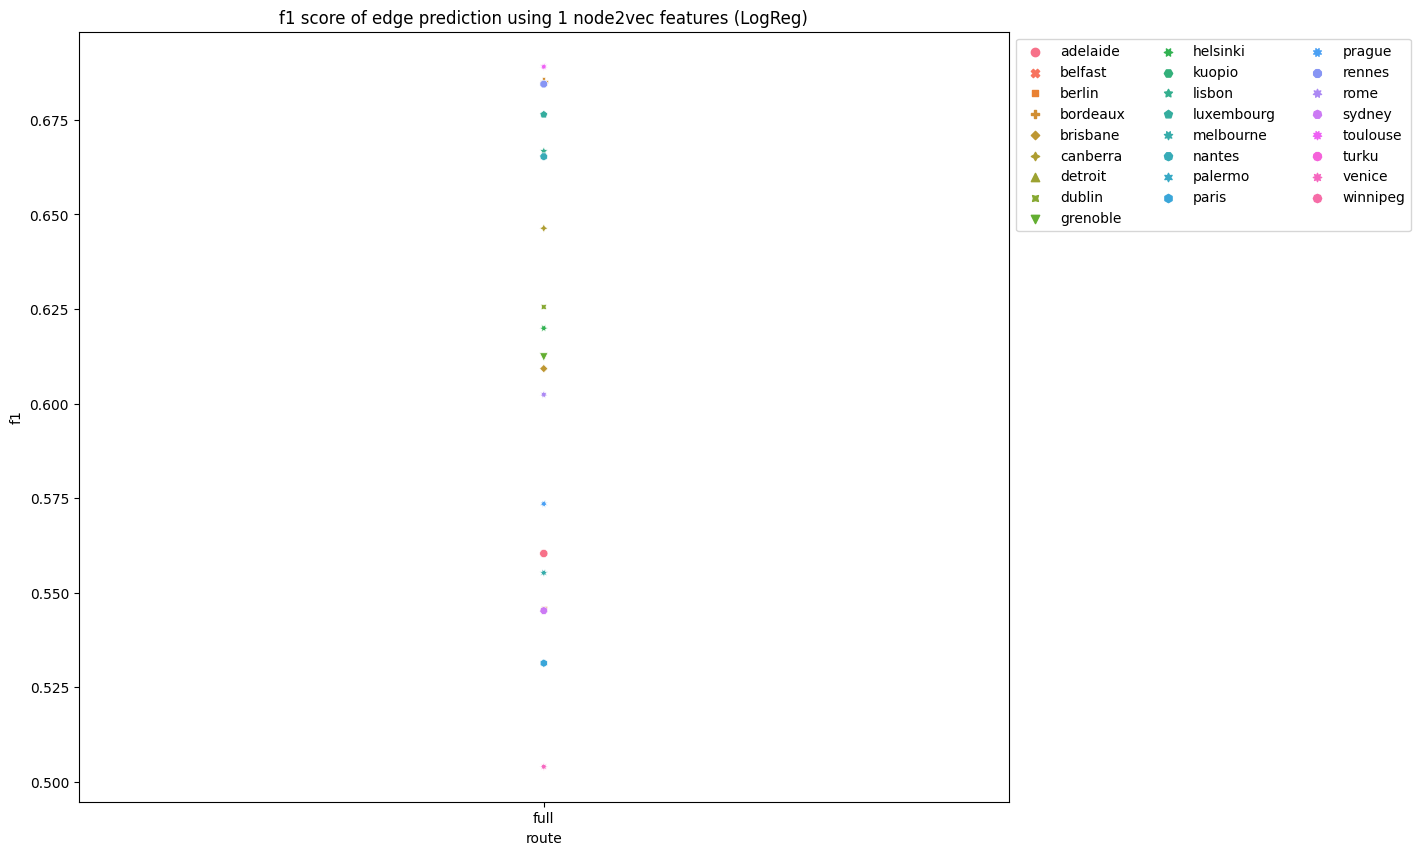

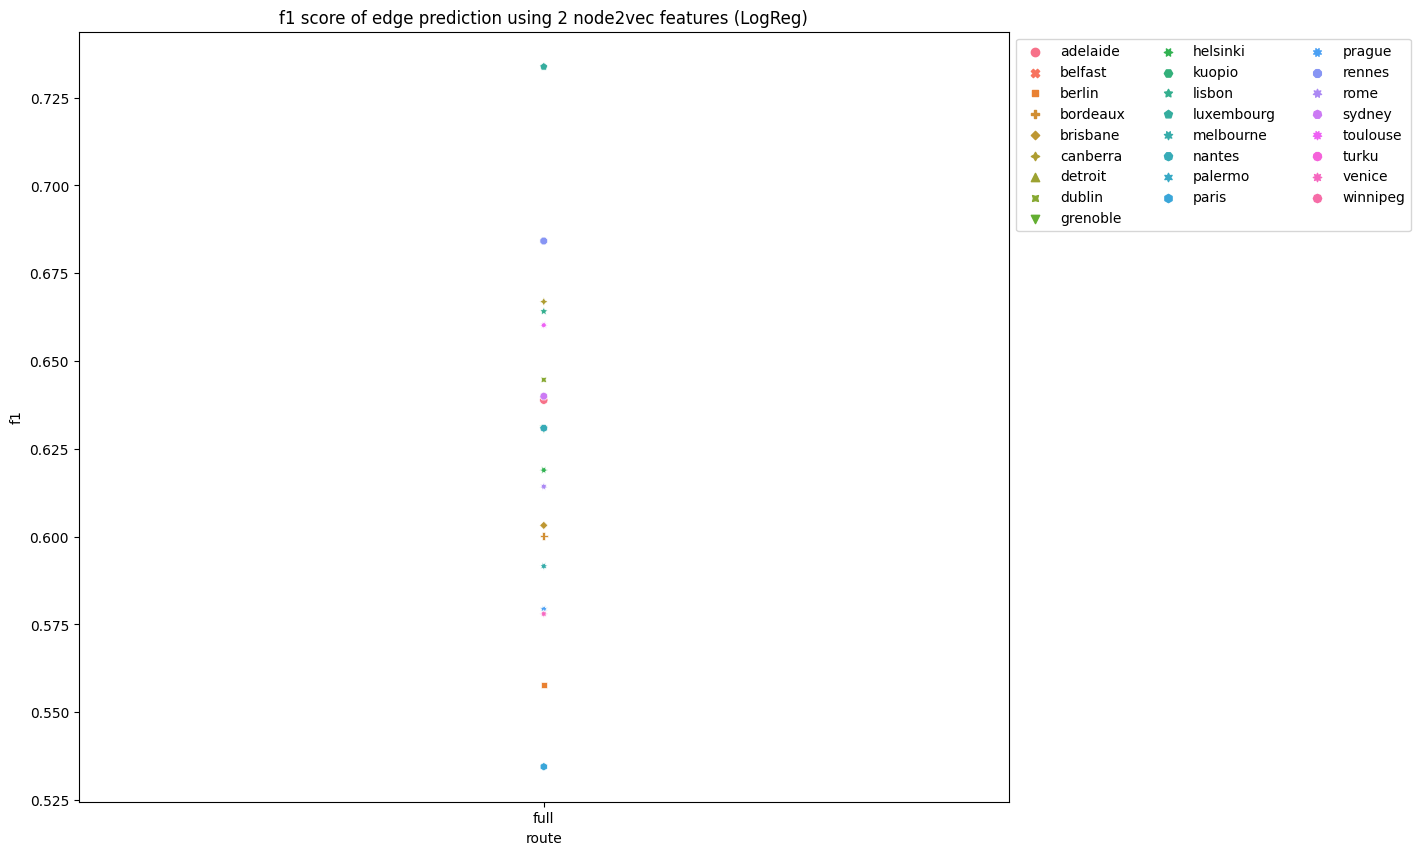

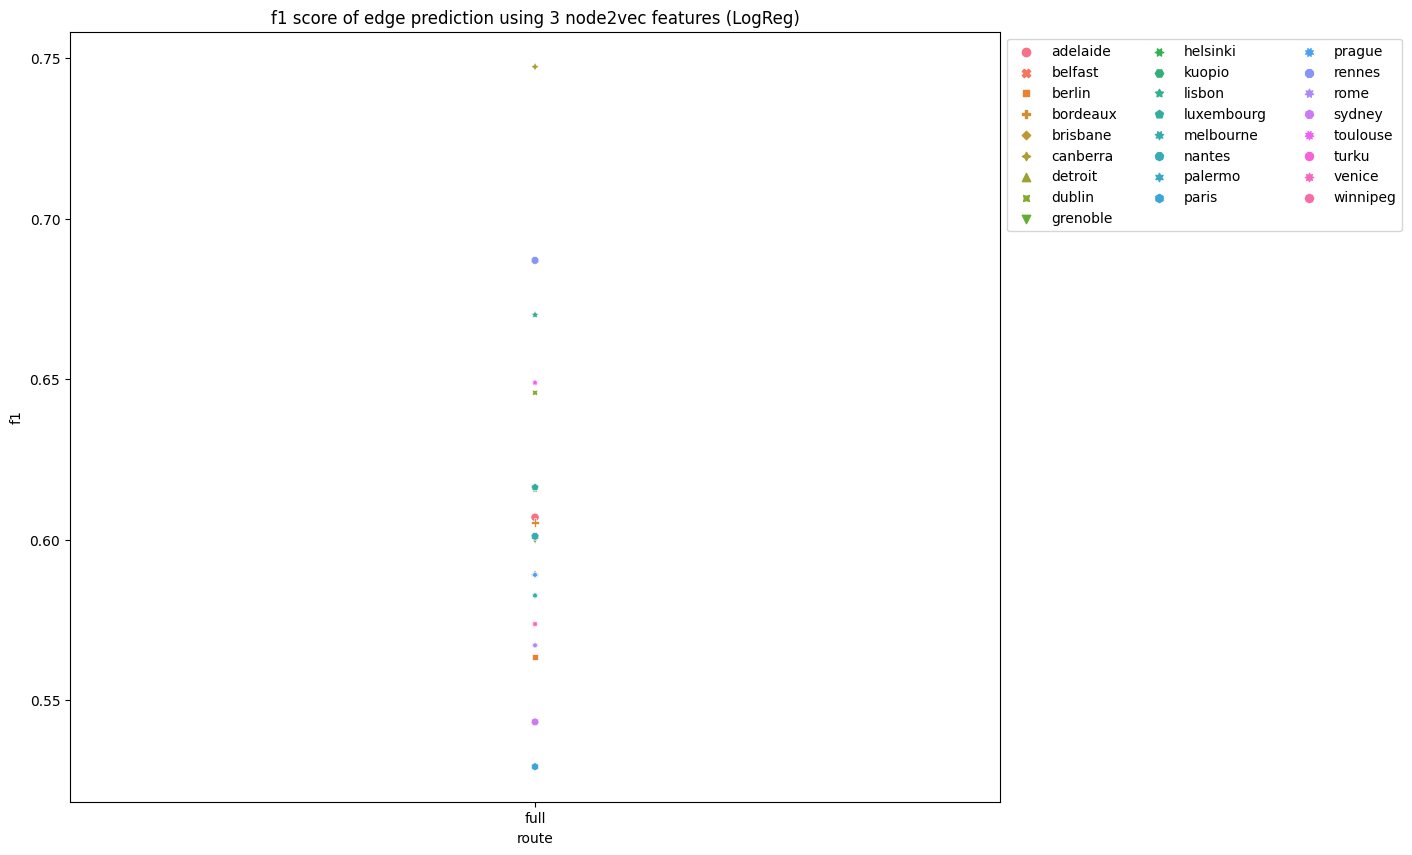

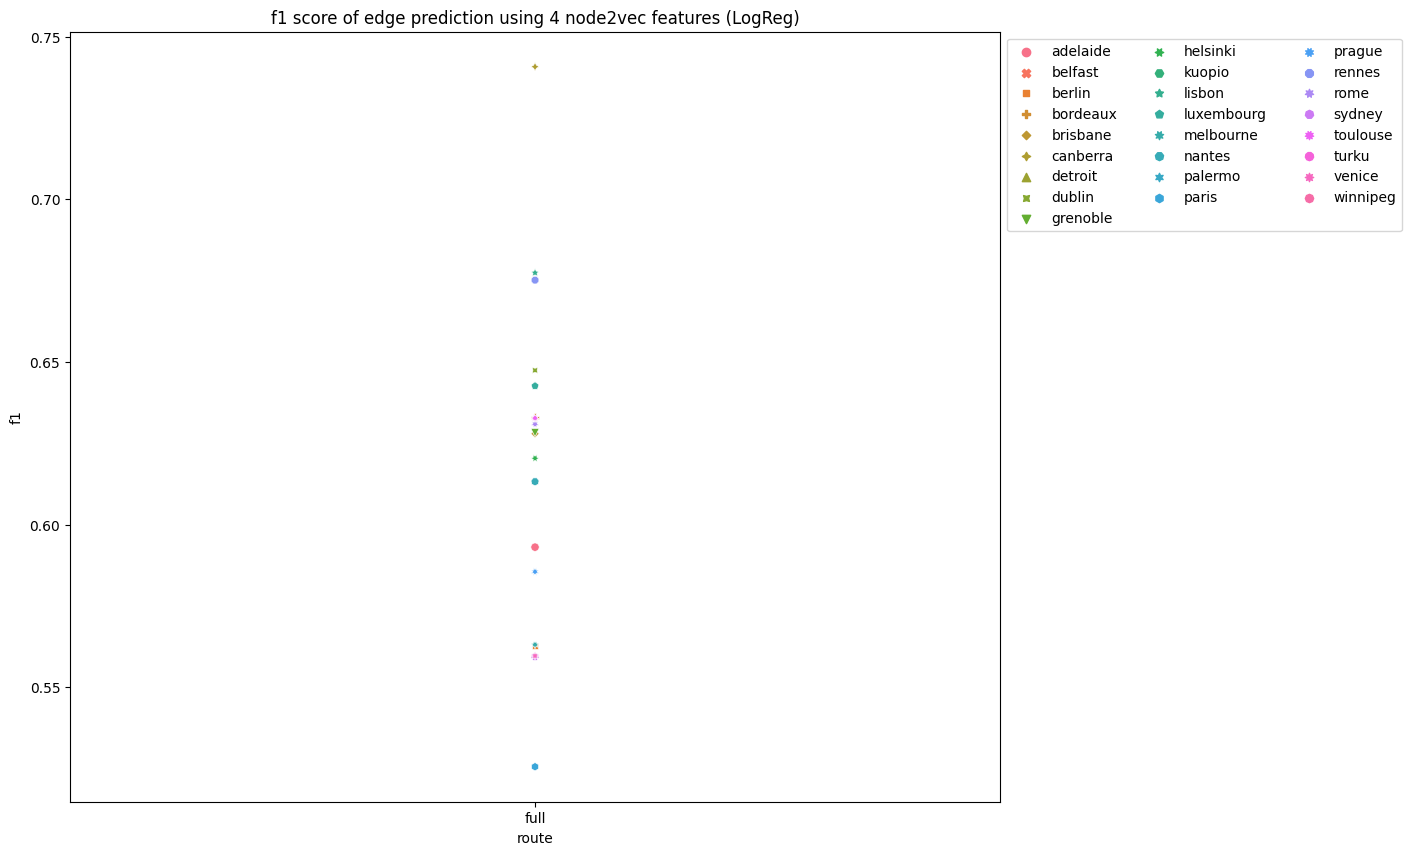

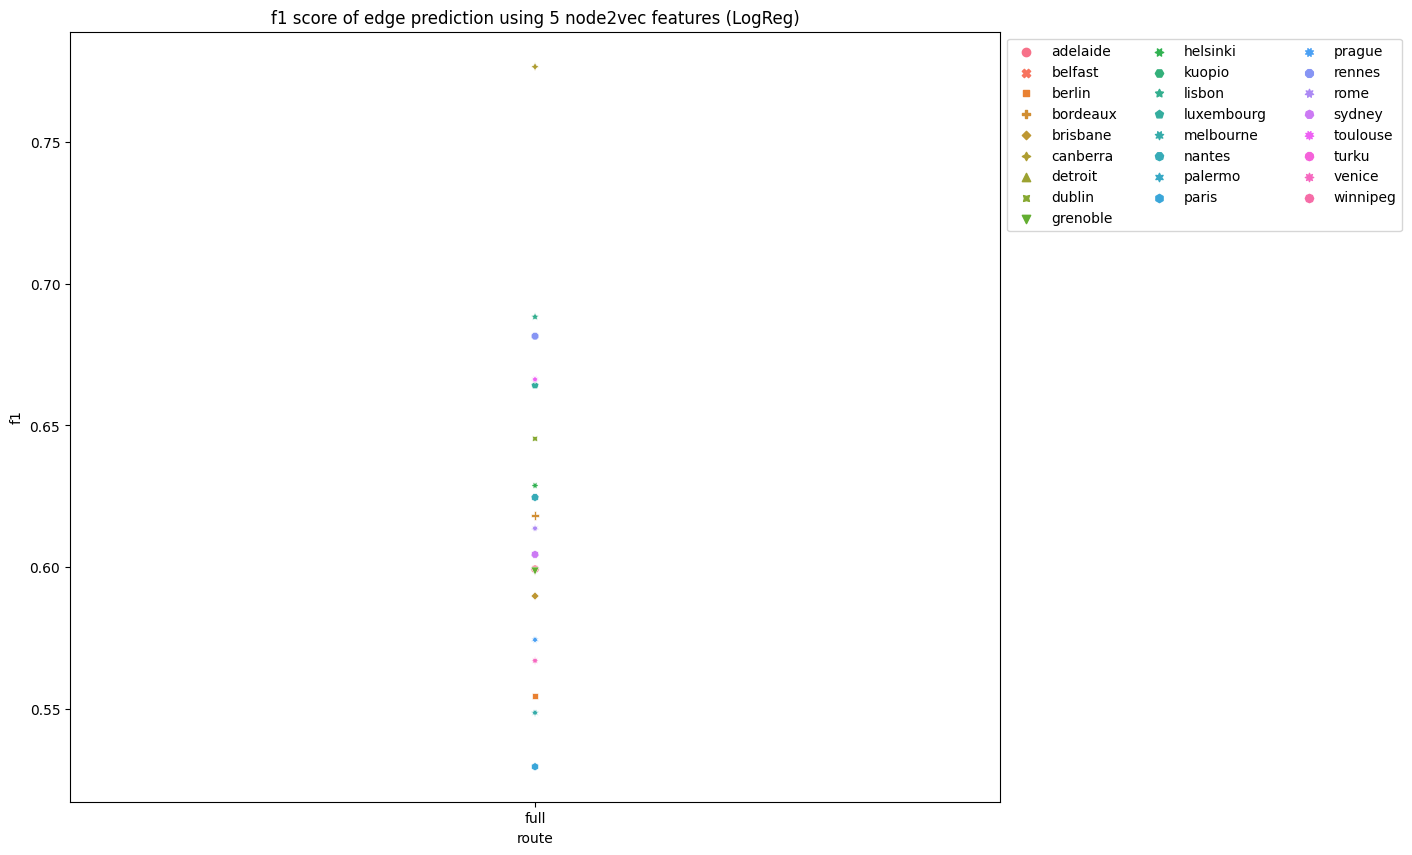

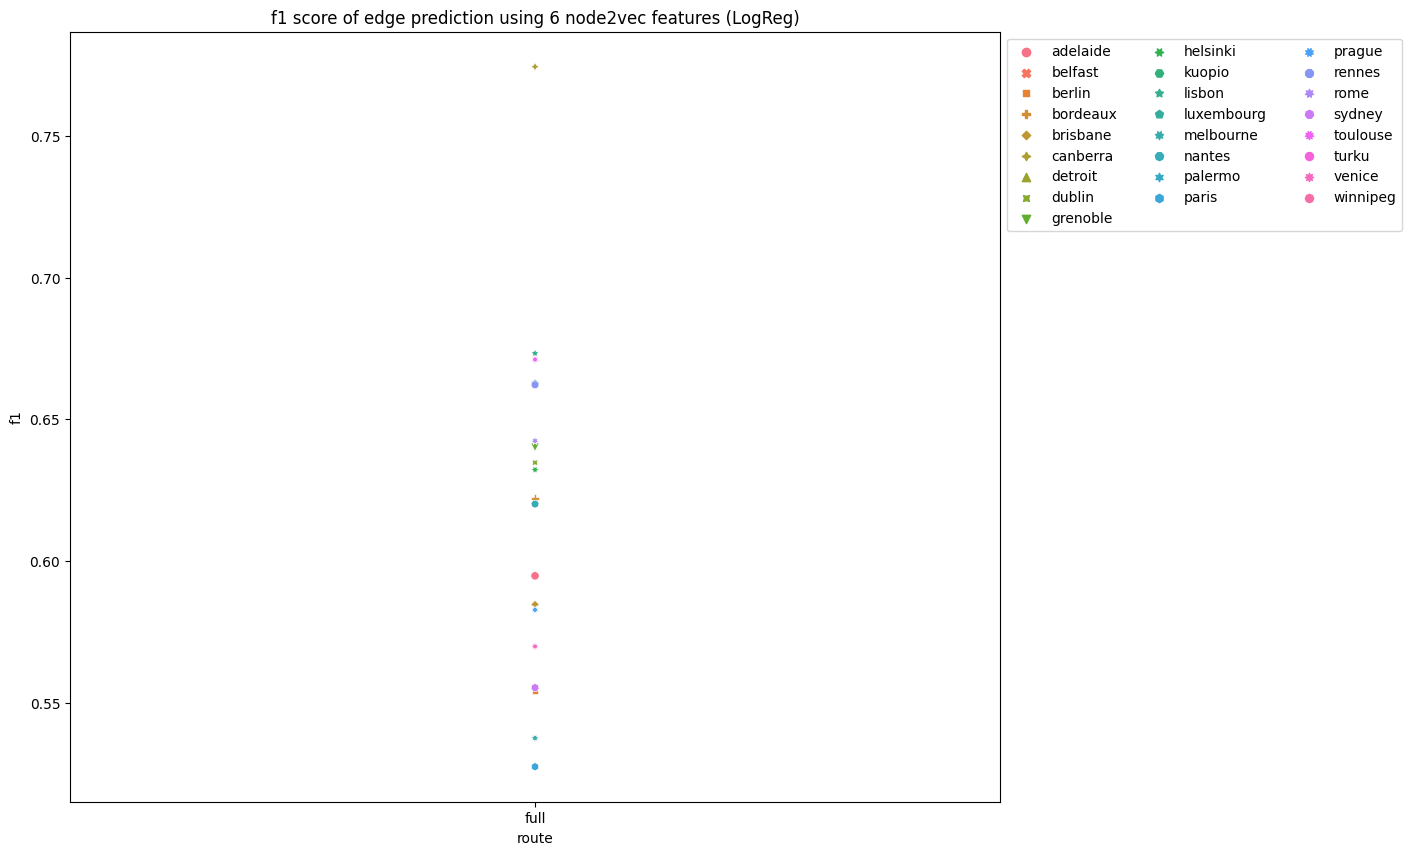

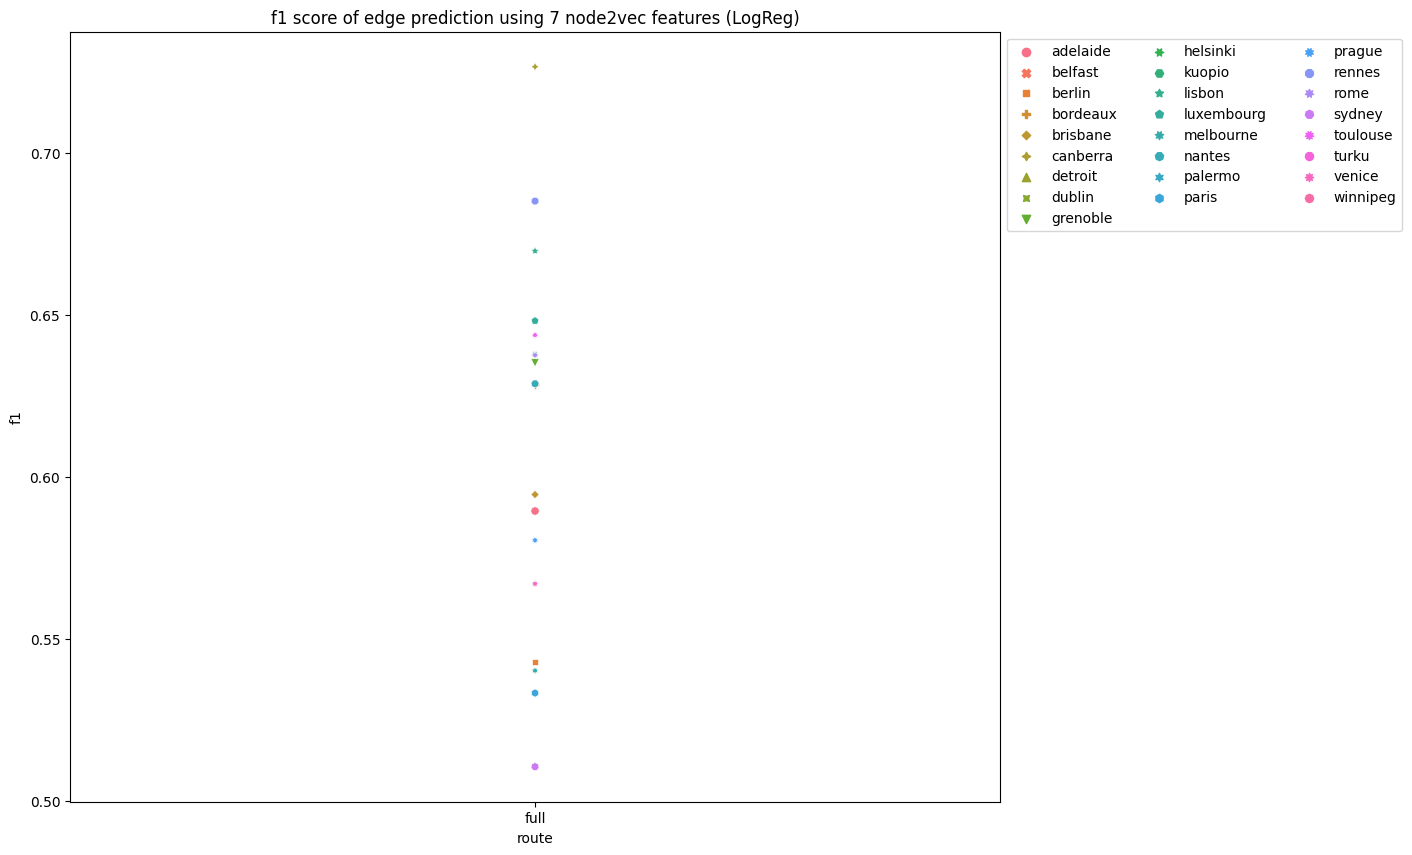

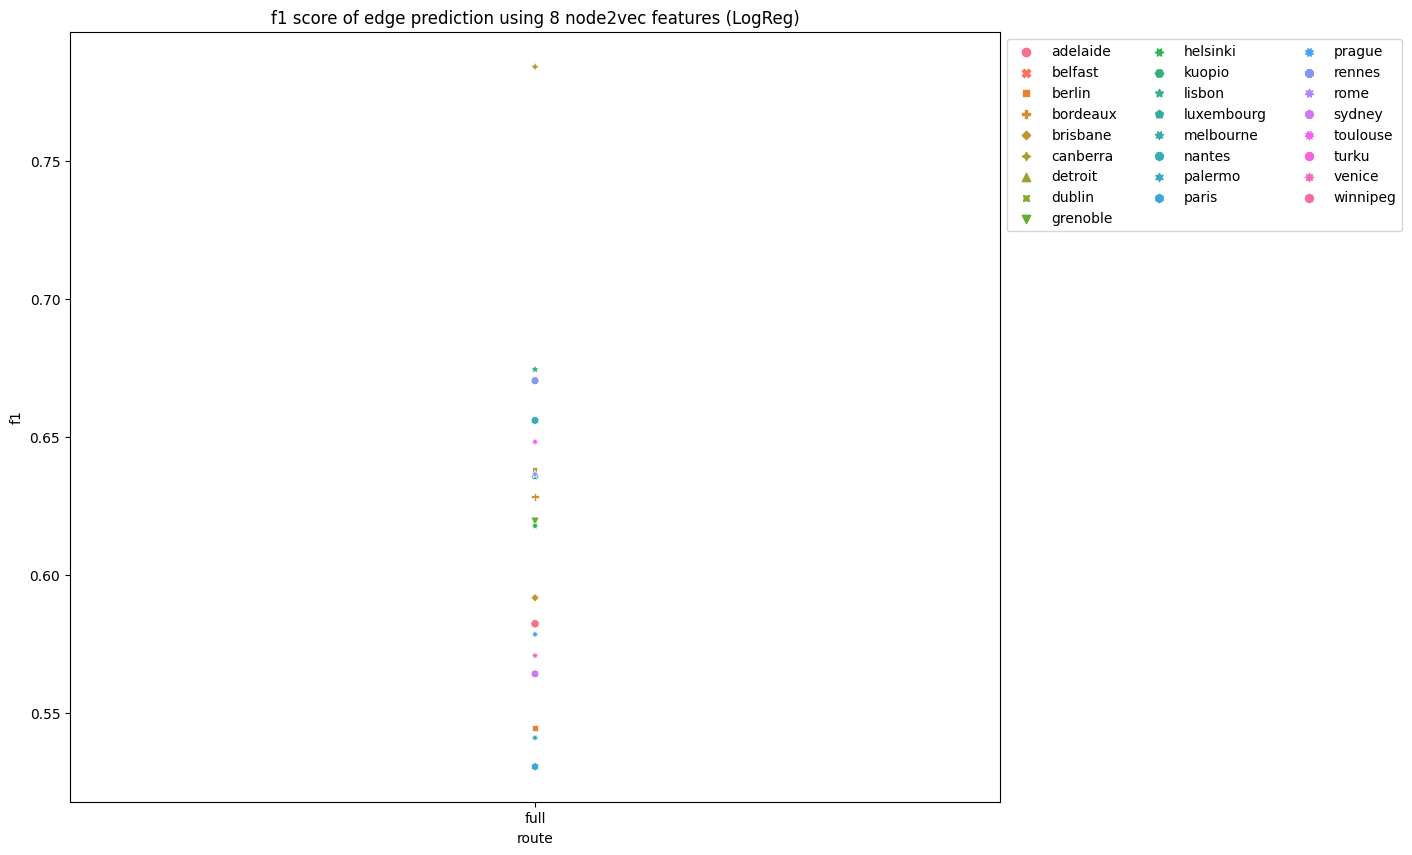

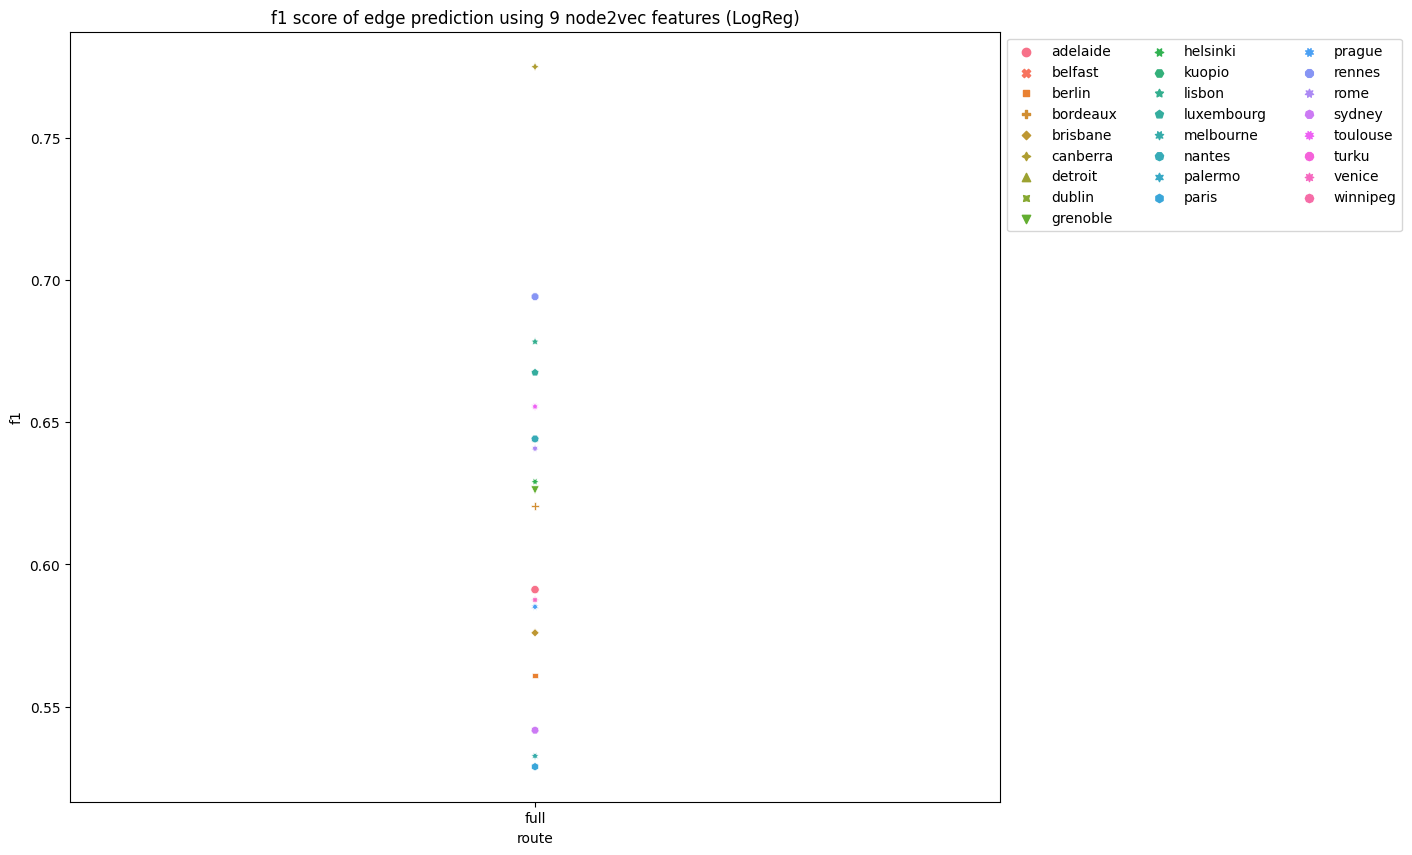

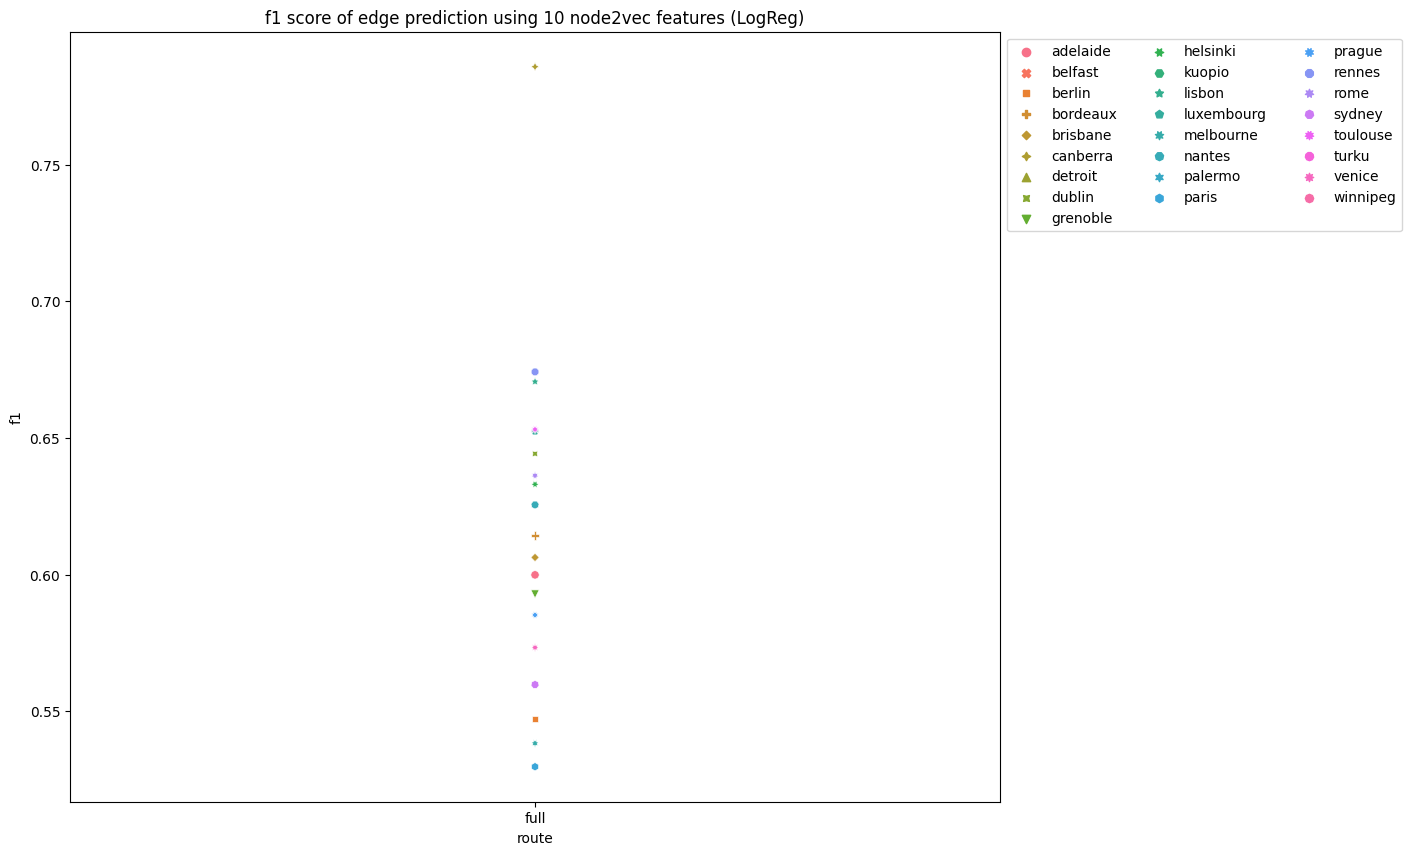

In [7]:
for num_features in tqdm(range(1, max_num_features + 1)):
    temp_path = city_network_graphs_dir_label_pred_node2vec.joinpath(str(num_features))
     
    cities_graphs_scores_n2v, cities_graphs_scores_n2v_df = read_scores(temp_path, modes_to_drop=[])
    
    plot_scores(cities_graphs_scores_n2v_df, num_features, features="node2vec")
    
    if num_features == 1:
        combined_result_df = cities_graphs_scores_n2v_df
    else:
        combined_result_df = pd.merge(combined_result_df,cities_graphs_scores_n2v_df,on = ['city', 'route'], suffixes=['','_{}'.format(num_features)])

In [8]:
f1_cols = ['f1', 'f1_2', 'f1_3', 'f1_4', 'f1_5', 'f1_6', 'f1_7',
       'f1_8', 'f1_9', 'f1_10']
combined_result_df['best'] = combined_result_df[f1_cols].idxmax(axis=1)
combined_result_df['best_score'] = combined_result_df[f1_cols].max(axis=1)

In [9]:
combined_result_df[["city", "route", "best"]].pivot(index='city', columns='route', values='best')

route,full
city,
adelaide,f1_2
belfast,NaN
berlin,f1_3
bordeaux,f1
brisbane,f1_4
canberra,f1_10
detroit,NaN
dublin,f1_7
grenoble,f1_6


In [10]:
combined_result_df[["city", "route", "best", "best_score"]].pivot(index='city', columns='route', values='best_score')

route,full
city,
adelaide,0.638852
belfast,NaN
berlin,0.563378
bordeaux,0.685124
brisbane,0.627933
canberra,0.785842
detroit,NaN
dublin,0.648318
grenoble,0.640173


In [11]:
a = combined_result_df[combined_result_df["route"] == "full"][["city"] + f1_cols]
a["mean"] = a[f1_cols].mean(axis=1)
a["std"] = a[f1_cols].std(axis=1)
a

,city,f1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,mean,std
typing.Literal[<no_default>],,,,,,,,,,,,,
0,adelaide,0.560354,0.638852,0.606947,0.593048,0.599281,0.594852,0.589419,0.582349,0.591159,0.599902,0.595616,0.019761
1,belfast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,berlin,0.545806,0.557809,0.563378,0.562560,0.554522,0.554376,0.542737,0.544680,0.560964,0.547019,0.553385,0.007820
3,bordeaux,0.685124,0.600156,0.605318,0.633010,0.618165,0.622174,0.628474,0.628418,0.620584,0.614284,0.625571,0.023317
4,brisbane,0.609240,0.603202,0.589157,0.627933,0.589800,0.584745,0.594513,0.591783,0.575972,0.606281,0.597263,0.014794
5,canberra,0.646346,0.666896,0.747276,0.740745,0.776619,0.774291,0.726638,0.784315,0.775068,0.785842,0.742404,0.049555
6,detroit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,dublin,0.625543,0.644645,0.645727,0.647400,0.645310,0.634759,0.648318,0.638067,0.643914,0.644217,0.641790,0.007054
8,grenoble,0.612317,0.630488,0.599918,0.628268,0.598573,0.640173,0.635207,0.619493,0.626194,0.592885,0.618352,0.016615


In this notebook, we use node2vec to do the label prediction. Similar to the handcrafted features setup, we predict labels of edges for cities that have more than one mode of transport. We try with 1 to 10 features with p and q set at 1.0.

For most of the cities, node2vec does not even perform as well as using the common features. However, for Berlin and Bordeaux node2vec improves compared to using node features, which was the best for them. For the city of Nantes, node2vec performs better than its best which uses the combined node and common features. 

Overall, we do not see the influence of the number of features on the performance of the model. Among the cities where node2vec performs better, Bordeaux and Nantes achieved the best performance with one feature and Berlin used three features.

However, this result did not tune the p,q parameters.